In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy import interpolate

from TO_sim.get_sec_r import get_r_Fun,get_rp,get_rp2,get_rp3,integrand_Rd3
from tqdm.notebook import tqdm
from parfor import parfor

In [2]:
# 저장된 npz 파일 로드
loaded_data = np.load('Simul/RR.npz', allow_pickle=True)
# 딕셔너리로 변환
RR = dict(loaded_data['RR'].item())  # .item()을 사용해 원래 딕셔너리로 변환

In [3]:
m = 6

In [4]:
Ks = np.arange(0,10.01,0.1)
ms = np.arange(0,10.02,0.1)

In [107]:
RR = {}
RR['u'] = {}
RR['d'] = {}
RR['u']['rp'] = {}
RR['d']['rp'] = {}
RR['u']['rp0'] = {}
RR['d']['rp0'] = {}

RR['u']['R'] = {}
RR['u']['R0'] = {}
RR['u']['SIG'] = {}
RR['u']['OPS'] = {}


In [ ]:
for m in tqdm(ms):
# @parfor (ms)
# def get_RR(m):
    F = get_r_Fun(m)
    R_0u = F['u']['R0'](Ks)
    idx = np.isnan(R_0u)
    K_urp = Ks[~idx]
    R_0u = R_0u[~idx]
    OPS = F['u']['OPS'](K_urp)
    _,rp_d,rp_u,rp0_d,rp0_u = get_rp(K_urp,R_0u,OPS,m,MAX=False)
    NN = np.nan* np.zeros_like(idx)[idx]
    RR['d']['rp'][m] = np.r_[NN,rp_d]
    RR['u']['rp'][m] = np.r_[NN,rp_u]
    RR['d']['rp0'][m] = np.r_[NN,rp0_d]
    RR['u']['rp0'][m] = np.r_[NN,rp0_u]
    RR['u']['R'][m] = F['u']['R'](Ks)
    RR['u']['R0'][m] = F['u']['R0'](Ks)
    sigma = 2*rp_u * np.sqrt(1/2  - m*K_urp*R_0u / (4*(4*m**2 * OPS**2 + 1)) - ((m*K_urp*R_0u)/(2*(m**2*OPS**2 + 1)))**2)
    RR['u']['SIG'][m] = np.r_[NN,rp0_u]
    RR['u']['OPS'][m] = np.r_[NN,OPS]


In [ ]:
# np.savez('Simul/RR_0.npz',RR=RR,ms=ms,Ks=Ks)

In [24]:
df_A = pd.read_excel(f'NEW Order parameter and secondary cluster NEW.xlsm',index_col=[0,1])
df_A2 = pd.read_excel('Order parameter and secondary cluster with rsecd.xlsm',index_col=[0,1])

In [5]:
N = 5000
df_new = pd.read_excel(f'N = {N} seed = 10 QNORMAL wo pv.xlsm',index_col=[0,1])

In [6]:
df = pd.DataFrame(RR)

In [48]:
A_RPU = pd.DataFrame(df['u']['rp'],index=Ks).to_numpy(dtype=float)
A_RPD = pd.DataFrame(df['d']['rp'],index=Ks).to_numpy(dtype=float)
A_RPU0 = pd.DataFrame(df['u']['rp0'],index=Ks).to_numpy(dtype=float)
A_RPD0 = pd.DataFrame(df['d']['rp0'],index=Ks).to_numpy(dtype=float)
A_R0 = pd.DataFrame(df['u']['R0'],index=Ks).to_numpy(dtype=float)
A_SIG = pd.DataFrame(df['u']['SIG'],index=Ks).to_numpy(dtype=float)

Text(0, 0.5, 'm')

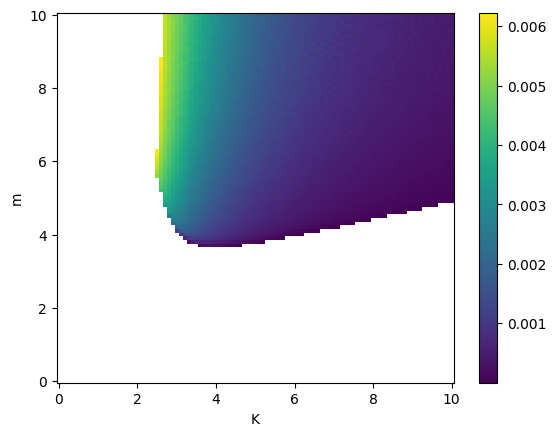

In [57]:
plt.pcolormesh(KK,MM,(A_RPU0 - A_RPU).T)
plt.colorbar()
plt.xlabel('K')
plt.ylabel('m')

In [34]:
RP = df_new['r+'].unstack().to_numpy(float)
R0 = df_new['r0'].unstack().to_numpy(float)
RM = df_new['r-'].unstack().to_numpy(float)
SIG_S = df_new['sig'].unstack().to_numpy(float)

In [9]:
DRP_AS = (A_RPU0 - RP) + (A_RPU0 - RM)
R0_SA = (R0 - A_R0) 
# np.nanmin(R0P), np.nanmax(R0P)

In [173]:
X = R0_SA.flatten()
Y = DRP_AS.flatten()
M_nnan = MM.flatten()[~np.isnan(Y)]
X_nnan = X[~np.isnan(Y)]
Y_nnan = Y[~np.isnan(Y)]
coefficients = np.polyfit(Y_nnan, X_nnan, 1)
fit_line = np.polyval(coefficients, Y_nnan)

# Calculate R-squared value for a line with slope=1 and intercept=0
fit_line_identity = Y_nnan  # y = x for slope=1 and intercept=0
residuals_identity = X_nnan - fit_line_identity
ss_res_identity = np.sum(residuals_identity**2)
ss_tot_identity = np.sum((X_nnan - np.mean(X_nnan))**2)
r_squared_identity = 1 - (ss_res_identity / ss_tot_identity)

print("R-squared for y=x:", r_squared_identity)
residuals = X_nnan - fit_line
ss_res = np.sum(residuals**2)
ss_tot = np.sum((X_nnan - np.mean(X_nnan))**2)
r_squared = 1 - (ss_res / ss_tot)

print("Coefficients:", coefficients)
print("R-squared:", r_squared)

R-squared for y=x: 0.8774408568595302
Coefficients: [0.82557334 0.00866989]
R-squared: 0.9240686626607668


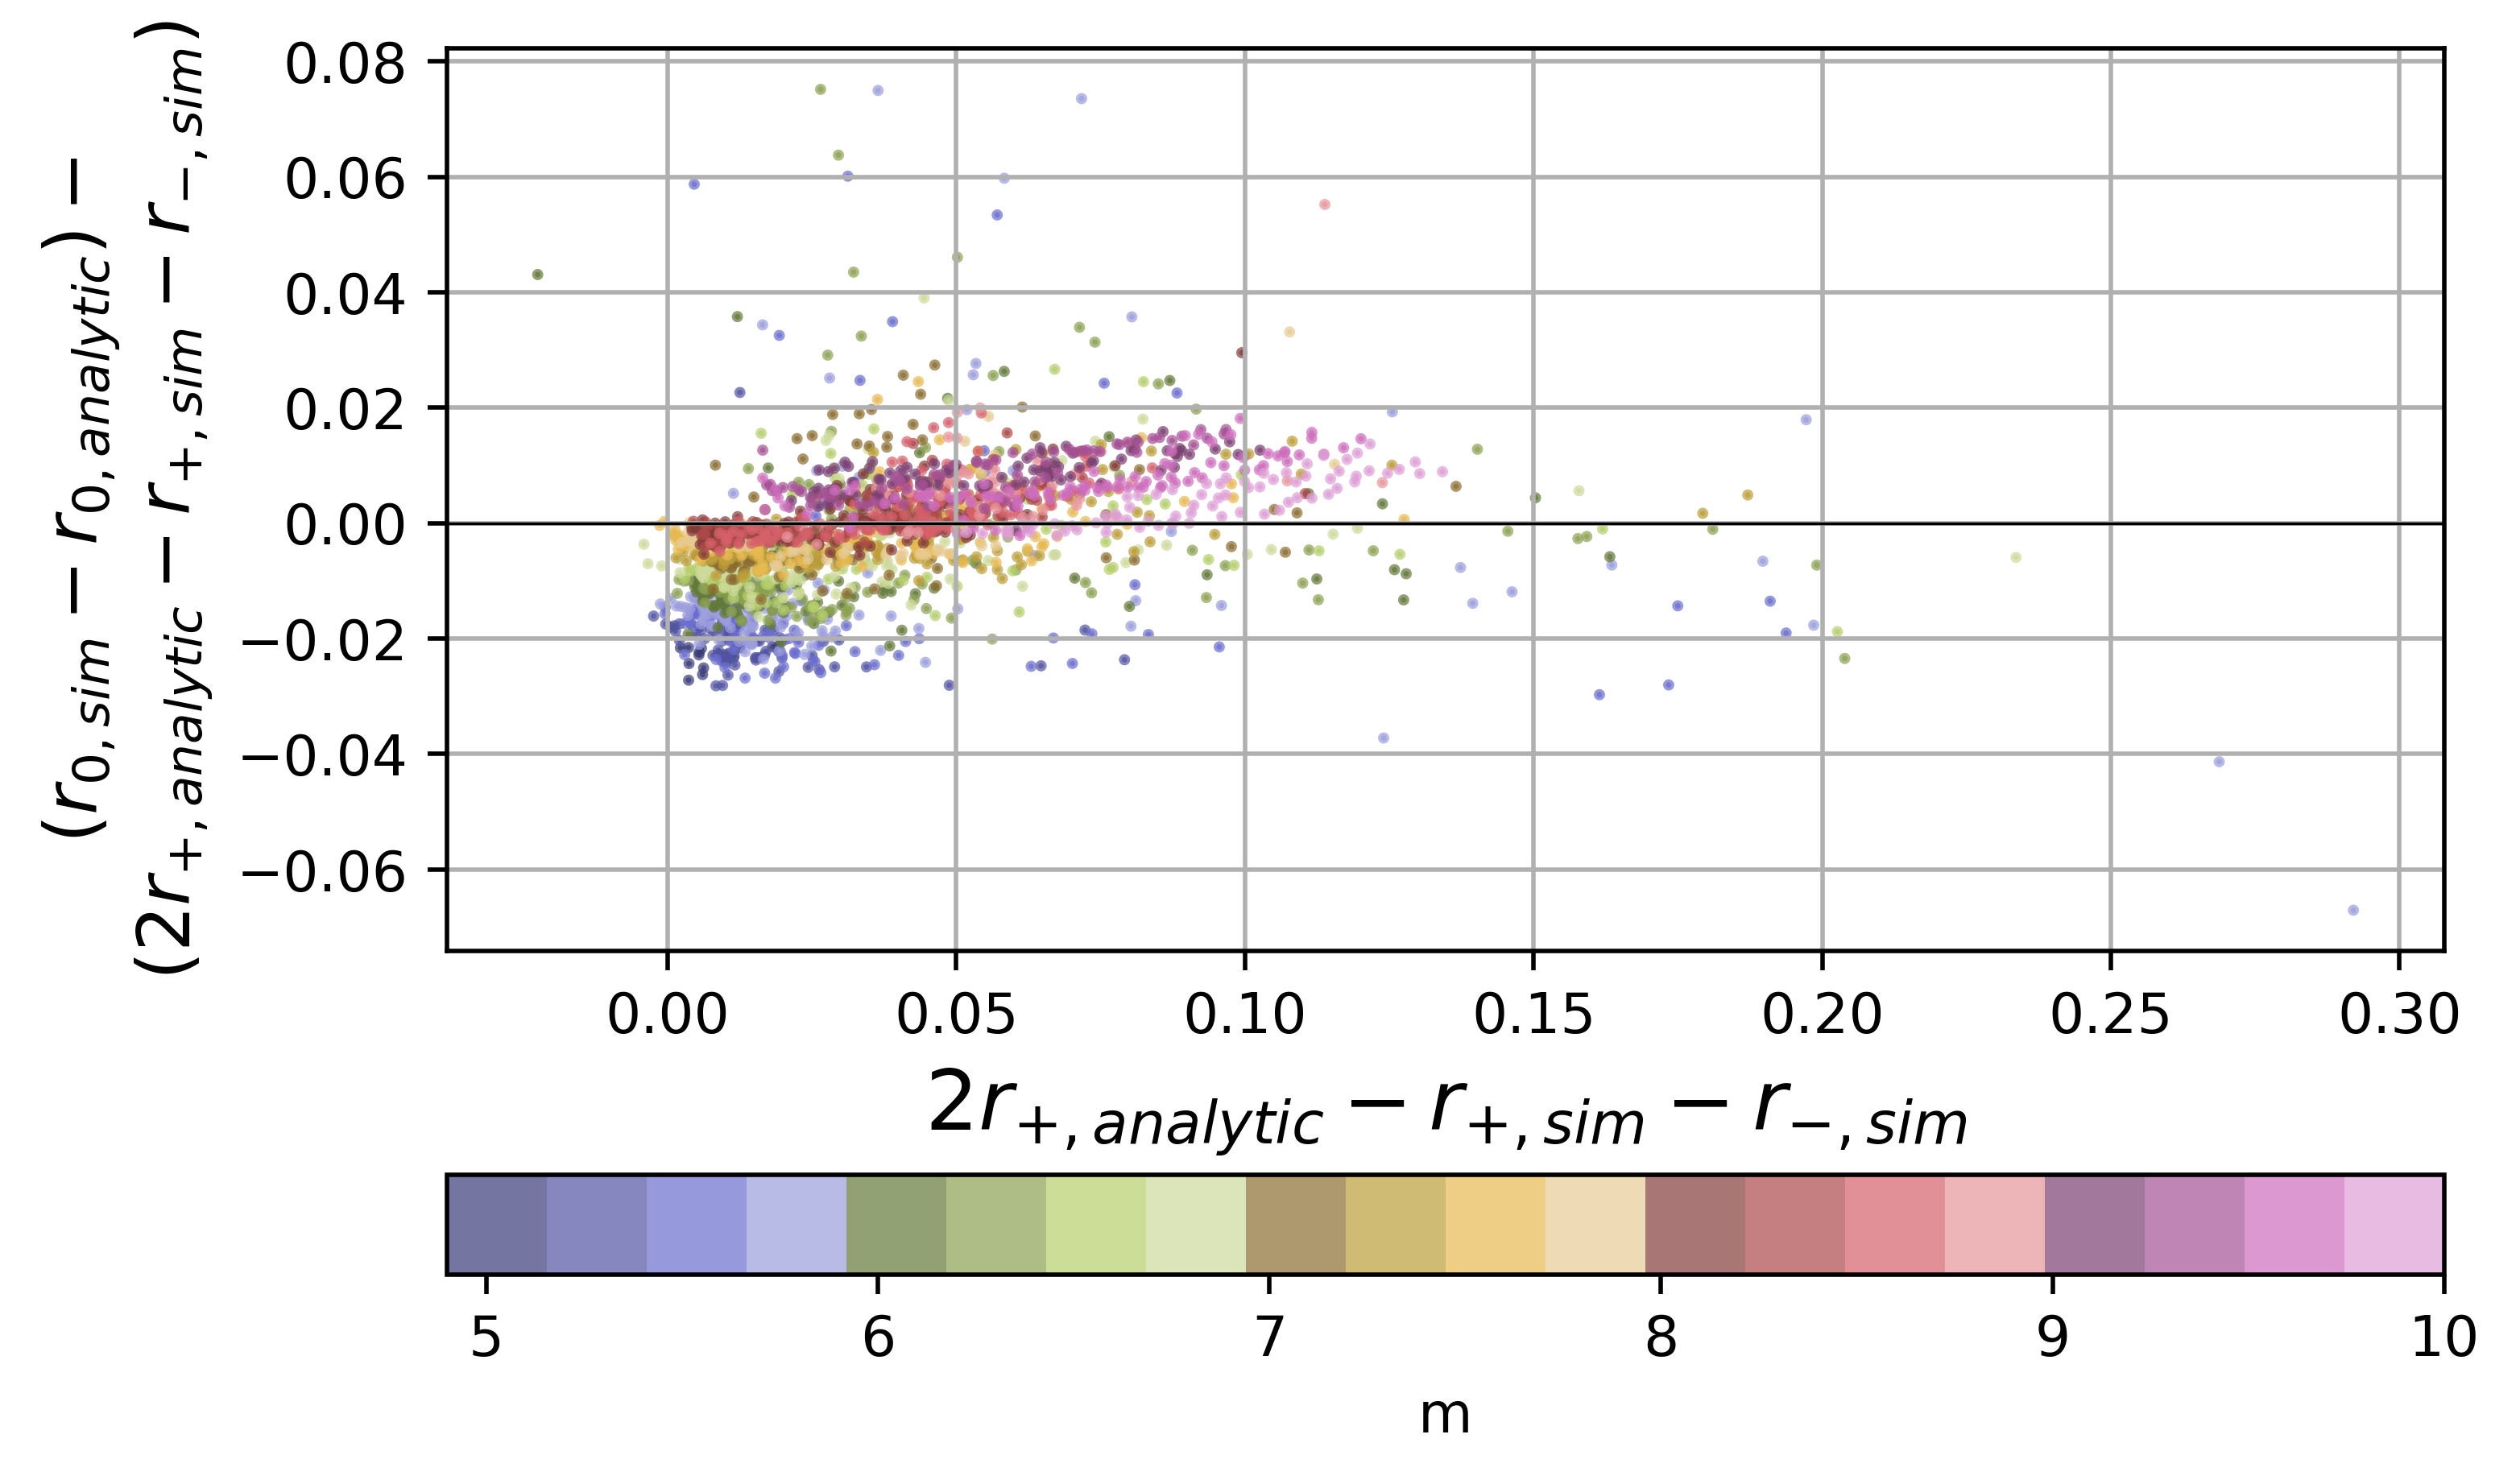

In [174]:
plt.figure(dpi=500)
# plt.plot(DRP_AS.flatten()*1.1,DRP_AS.flatten()*1.1,zorder=1,c='k',lw=0.5)
plt.axhline(0,c='k',lw=0.5)
plt.scatter(R0_SA.flatten(),DRP_AS.flatten()-R0_SA.flatten(),s=1,c=MM.flatten(),alpha=0.7,cmap='tab20b')
plt.gca().set_aspect('equal', adjustable='box')
plt.ylabel(r'$(r_{0,sim}-r_{0,analytic})-$' + '\n' + r'$(2r_{+,analytic}-r_{+,sim}-r_{-,sim})$', fontsize=13)
plt.xlabel(r'$2r_{+,analytic}-r_{+,sim}-r_{-,sim}$',fontsize=15)
plt.colorbar(label='m',orientation='horizontal')
plt.grid()


In [182]:
from scipy.stats import pearsonr

X = R0_SA.flatten()
Y =DRP_AS.flatten() 
XX = X[~np.isnan(X) & ~np.isnan(Y)]
YY = Y[~np.isnan(X) & ~np.isnan(Y)]
correlation, _ = pearsonr(X[~np.isnan(X) & ~np.isnan(Y)], Y[~np.isnan(X) & ~np.isnan(Y)])
print("Pearson correlation:", correlation)

Pearson correlation: 0.9612849019207411


In [185]:
COV = np.cov(XX,YY) [1,1]
PEARSON = COV / (np.std(XX) * np.std(YY))
print("Pearson correlation:", PEARSON)


Pearson correlation: 1.1649438911377237


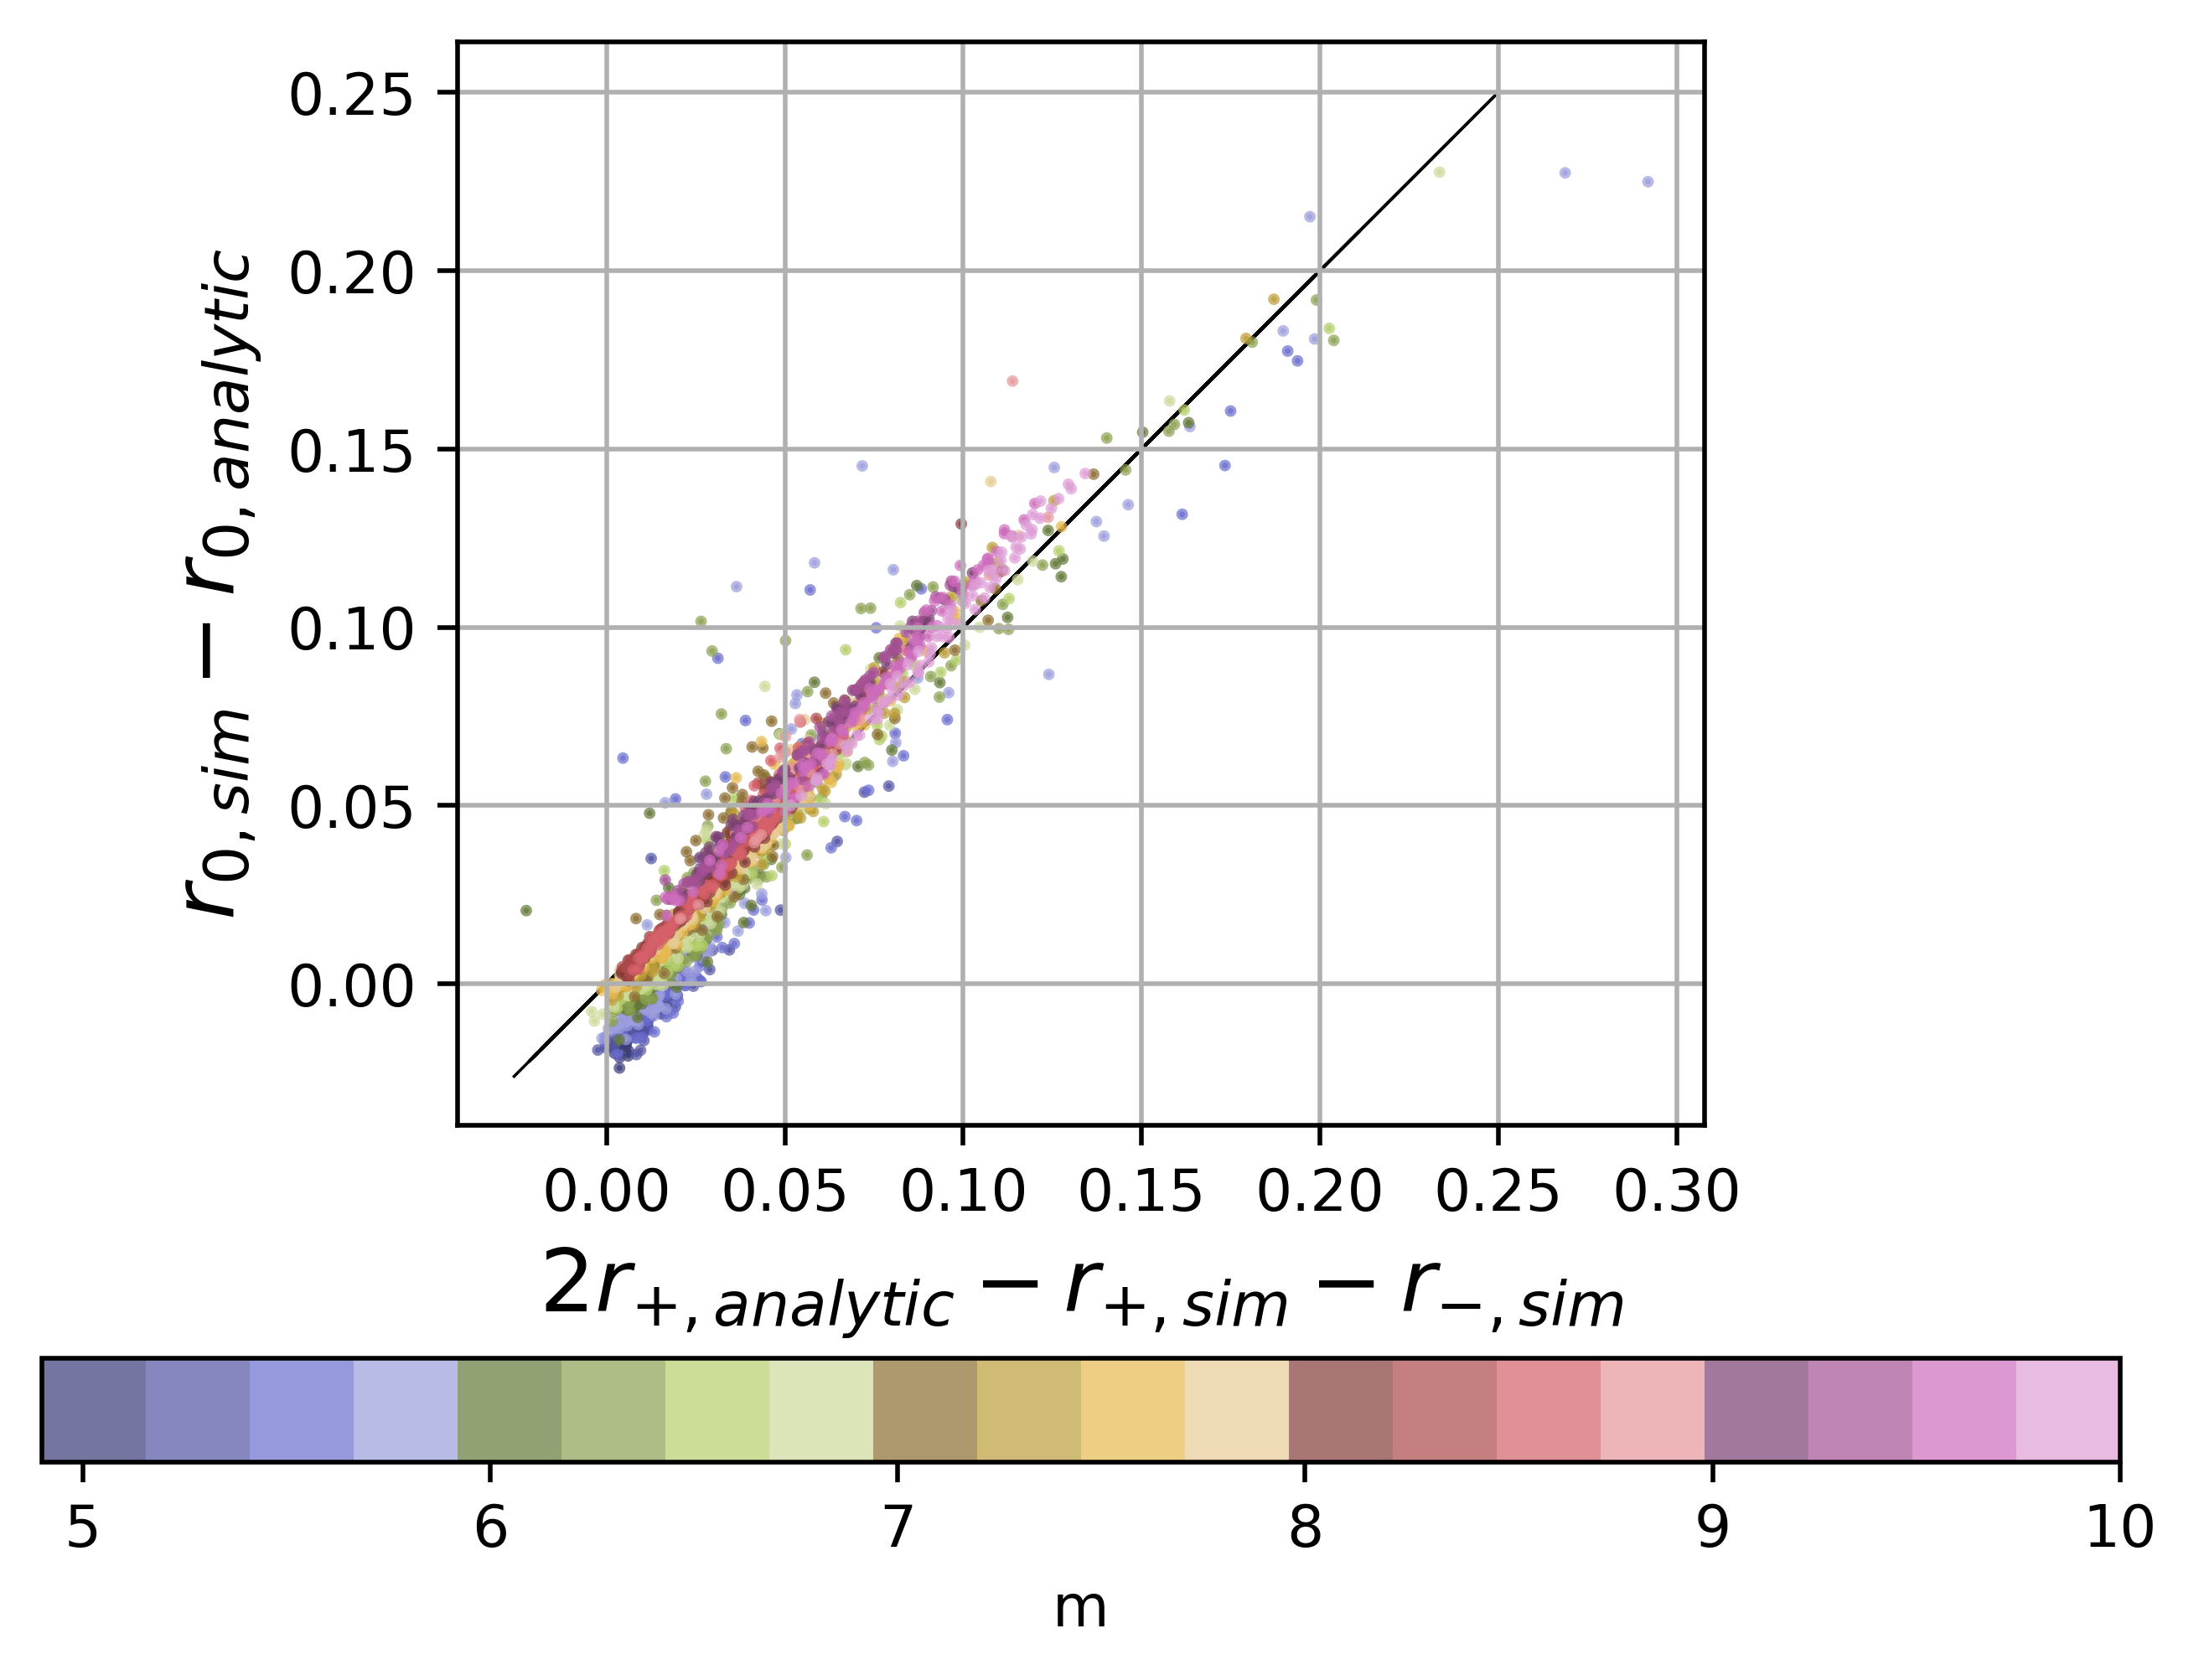

In [176]:
plt.figure(dpi=500)
plt.plot(DRP_AS.flatten()*1.1,DRP_AS.flatten()*1.1,zorder=1,c='k',lw=0.5)
plt.scatter(R0_SA.flatten(),DRP_AS.flatten(),s=1,c=MM.flatten(),alpha=0.7,cmap='tab20b')
plt.gca().set_aspect('equal', adjustable='box')
plt.ylabel(r'$r_{0,sim}-r_{0,analytic}$',fontsize=15)
plt.xlabel(r'$2r_{+,analytic}-r_{+,sim}-r_{-,sim}$',fontsize=15)
plt.colorbar(label='m',orientation='horizontal')
plt.grid()

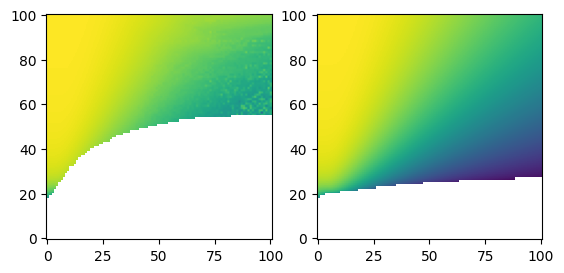

In [125]:
plt.subplot(121)
plt.imshow(R0,origin='lower')
plt.subplot(122)

plt.imshow(R0A,origin='lower')

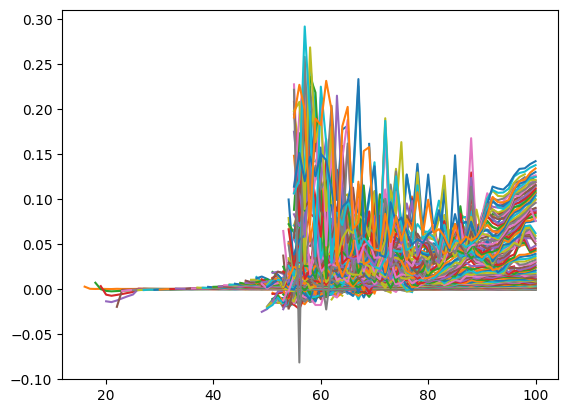

In [126]:
plt.plot(DRP_AS);
plt.plot(R0_SA);

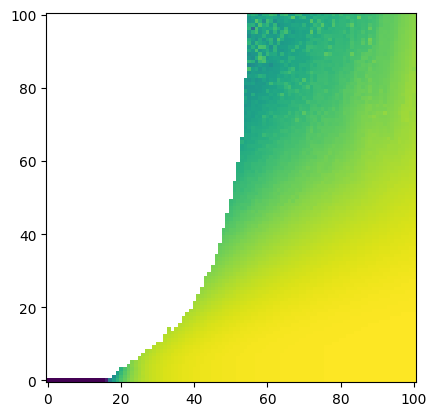

In [207]:
plt.imshow(R0.T,origin='lower')

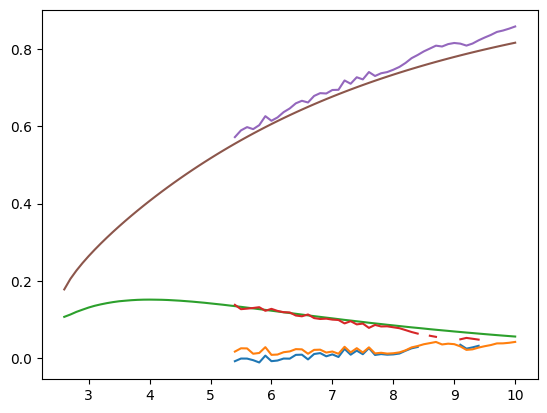

In [127]:
plt.plot(Ks,DRP_AS[:,70])
plt.plot(Ks,R0_SA[:,70])
plt.plot(Ks,RPU[:,70])
plt.plot(Ks,RP[:,70])
plt.plot(Ks,R0[:,70])
plt.plot(Ks,R0A[:,70])

In [158]:
A_R0P = A_R0 + 2 * A_RPU0
S_R0P = R0 + RP + RM


In [159]:
np.nanmax(A_R0P)
np.nanmax(S_R0P)

0.9300112143676389

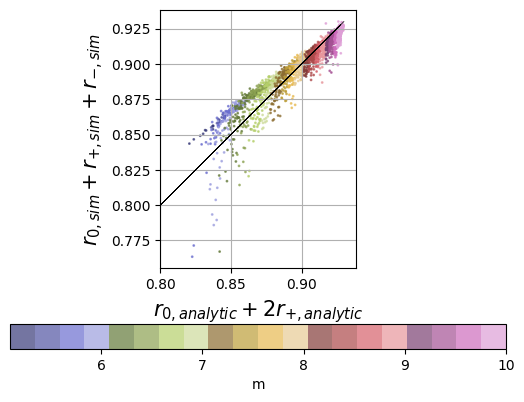

In [161]:
plt.scatter(A_R0P.flatten(),S_R0P.flatten(),s=1,c=MM.flatten(),alpha=0.7,cmap='tab20b')
plt.plot(S_R0P.flatten(),S_R0P.flatten(),c='k',lw=0.5)
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(0.8,)
plt.ylabel(r'$r_{0,sim}+r_{+,sim}+r_{-,sim}$',fontsize=15)
plt.xlabel(r'$r_{0,analytic}+2r_{+,analytic}$',fontsize=15)
plt.colorbar(label='m',orientation='horizontal')
plt.grid()

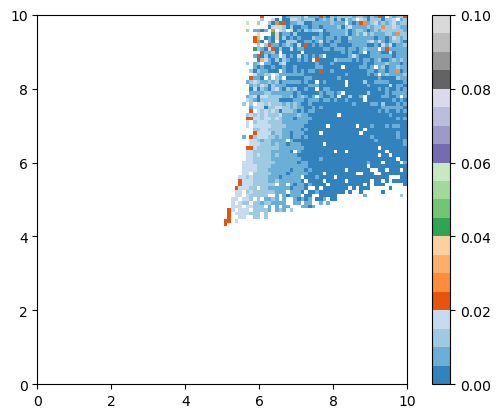

In [90]:
plt.imshow(abs(R0_SA.T - DRP_AS.T),origin='lower',vmin=0,vmax=0.1,cmap='tab20c',extent=[Ks.min(), 10, ms.min(),10])
# plt.contourf(abs(R0_SA.T - DRP_AS.T),origin='lower')#,vmin=0,vmax=0.3,cmap='tab20c',extent=[Ks.min(), 10, ms.min(),10])
plt.colorbar()

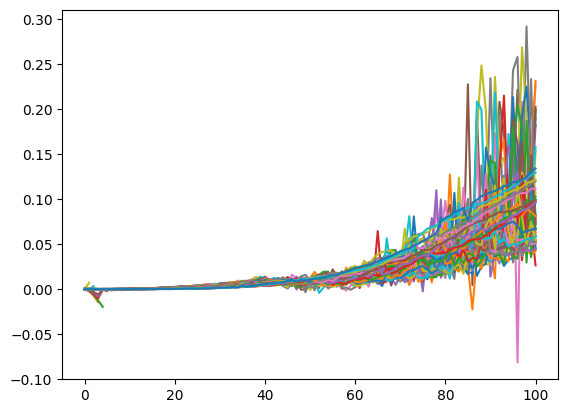

In [208]:
# plt.plot(R0A.T);
plt.plot((R0-R0A).T);

In [ ]:
# RP,R0,RM : 시뮬레이션 결과
# RPU, RPD, RPU0, RPD0 : 이론 결과
# DRP_AS = (2*RPU) - (RM + RP)
# R0_SA = (R0 - R0A) 
# np.nanmin(R0P), np.nanmax(R0P)

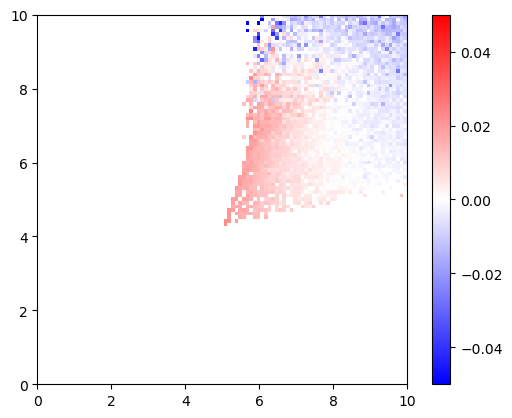

In [93]:
plt.imshow((S_R0P - A_R0P).T,origin='lower',vmin=-0.05,vmax=0.05,cmap='bwr',extent=[Ks.min(), 10, ms.min(),10])
plt.colorbar()

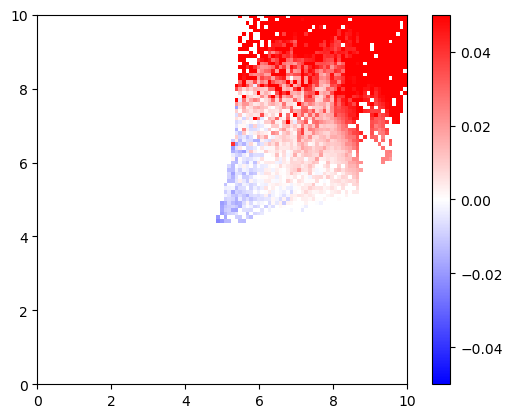

In [40]:
plt.imshow(DRP_AS.T,origin='lower',vmin=-0.05,vmax=0.05,cmap='bwr',extent=[Ks.min(), 10, ms.min(),10])
plt.colorbar()

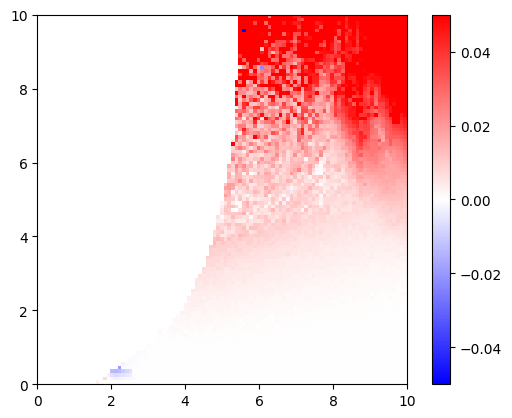

In [212]:
plt.imshow(R0_SA.T,origin='lower',vmin=-0.05,vmax=0.05,cmap='bwr',extent=[Ks.min(), 10, ms.min(),10])
plt.colorbar()  

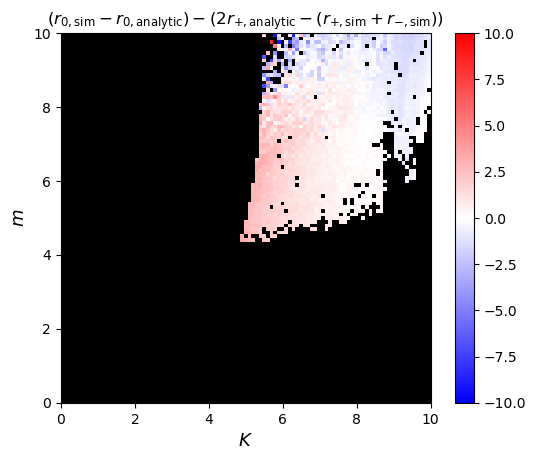

In [49]:
plt.imshow((100*(S_R0P - A_R0P)/A_R0P).T, origin='lower', vmin=-10, vmax=10, cmap='bwr', extent=[Ks.min(), 10, ms.min(), 10])
plt.gca().set_facecolor('black')  # Set the background color of the plot
# R0_SA : 메인 클러스터가 2차 클러스터를 흡수한 양
# DRP_AS : 2차 클러스터가 메인클러스터에 흡수된 양
# plt.contourf((R0_SA.T - DRP_AS.T), origin='lower', vmin=-0.1, vmax=0.1, levels=20, cmap='tab20c', extent=[Ks.min(), 10, ms.min(), 10])

plt.ylabel(r'$m$', fontsize=13)
plt.xlabel(r'$K$', fontsize=13)
plt.title(r'$(r_{0,\rm{sim}} - r_{0,\rm{analytic}}) - (2 r_{+,\rm{analytic}} - (r_{+,\rm{sim}} + r_{-,\rm{sim}}) )$')
# plt.contourf(abs(R0_SA.T - DRP_AS.T), origin='lower')#, vmin=0, vmax=0.3, cmap='tab20c', extent=[Ks.min(), 10, ms.min(), 10])
plt.colorbar()

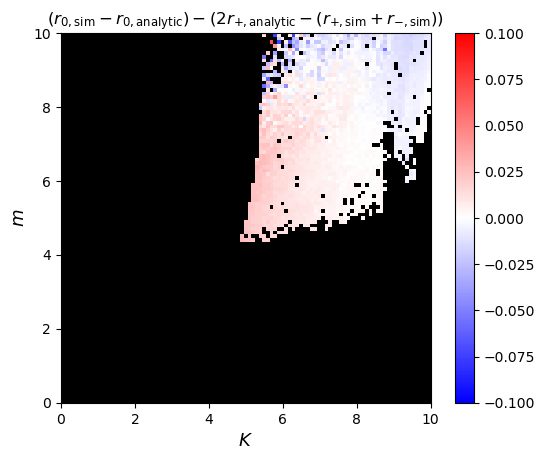

In [ ]:
plt.imshow((R0_SA.T - DRP_AS.T), origin='lower', vmin=-0.1, vmax=0.1, cmap='bwr', extent=[Ks.min(), 10, ms.min(), 10])
plt.gca().set_facecolor('black')  # Set the background color of the plot
# R0_SA : 메인 클러스터가 2차 클러스터를 흡수한 양
# DRP_AS : 2차 클러스터가 메인클러스터에 흡수된 양
# plt.contourf((R0_SA.T - DRP_AS.T), origin='lower', vmin=-0.1, vmax=0.1, levels=20, cmap='tab20c', extent=[Ks.min(), 10, ms.min(), 10])

plt.ylabel(r'$m$', fontsize=13)
plt.xlabel(r'$K$', fontsize=13)
plt.title(r'$(r_{0,\rm{sim}} - r_{0,\rm{analytic}}) - (2 r_{+,\rm{analytic}} - (r_{+,\rm{sim}} + r_{-,\rm{sim}}) )$')
# plt.contourf(abs(R0_SA.T - DRP_AS.T), origin='lower')#, vmin=0, vmax=0.3, cmap='tab20c', extent=[Ks.min(), 10, ms.min(), 10])
plt.colorbar()

In [155]:
A = np.where(SIG_S > 1e-2)

In [156]:
B = np.where(SIG_S > 5e-3,abs(SIG_S -SIG),np.nan)

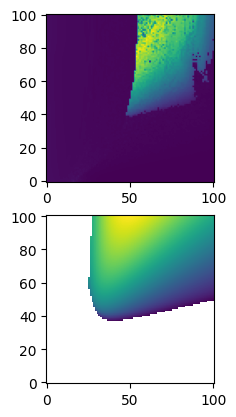

In [153]:
plt.subplot(211)
plt.imshow(SIG_S.T,origin='lower')
plt.subplot(212)
plt.imshow(SIG.T,origin='lower')

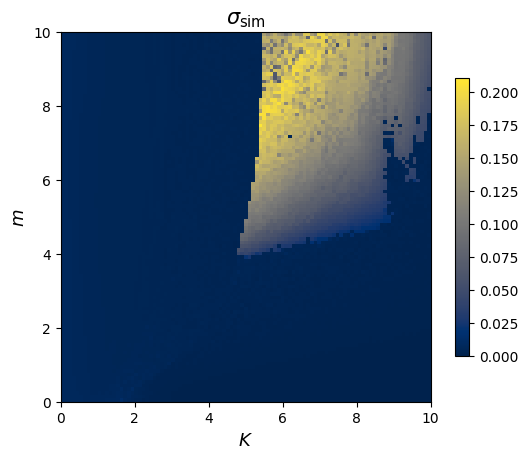

In [145]:
plt.imshow(SIG_S.T,origin='lower',vmin=0,cmap='cividis',extent=[Ks.min(), 10, ms.min(),10])
plt.colorbar(shrink=0.75)
plt.ylabel(r'$m$',fontsize=13)
plt.xlabel(r'$K$',fontsize=13)
plt.title(r'$\sigma_{\rm{sim}}$', fontsize=15)
plt.gca().set_aspect('equal')

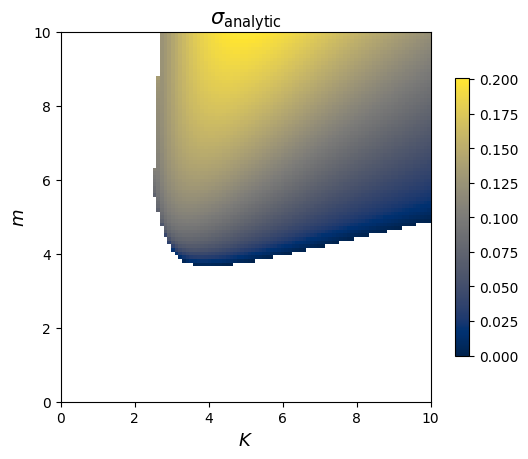

In [146]:
plt.imshow(SIG.T,origin='lower',vmin=0,cmap='cividis',extent=[Ks.min(), 10, ms.min(),10])
plt.colorbar(shrink=0.75)
plt.ylabel(r'$m$',fontsize=13)
plt.xlabel(r'$K$',fontsize=13)
plt.title(r'$\sigma_{\rm{analytic}}$', fontsize=15)
plt.gca().set_aspect('equal')

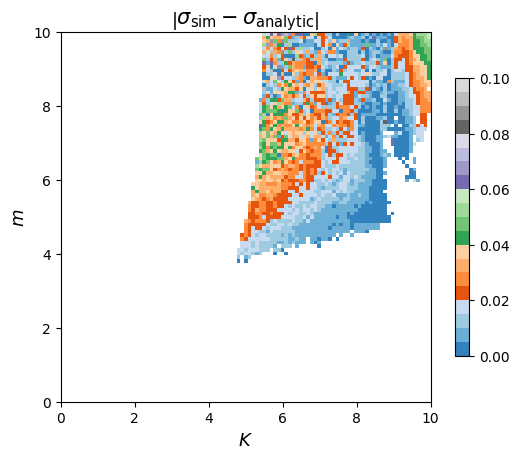

In [158]:
plt.imshow(B.T,origin='lower',vmin=0,vmax=0.1,cmap='tab20c',extent=[Ks.min(), 10, ms.min(),10])
plt.colorbar(shrink=0.75)
plt.ylabel(r'$m$',fontsize=13)
plt.xlabel(r'$K$',fontsize=13)
plt.title(r'$\left|\sigma_{\rm{sim}} - \sigma_{\rm{analytic}}\right|$', fontsize=15)
plt.gca().set_aspect('equal')

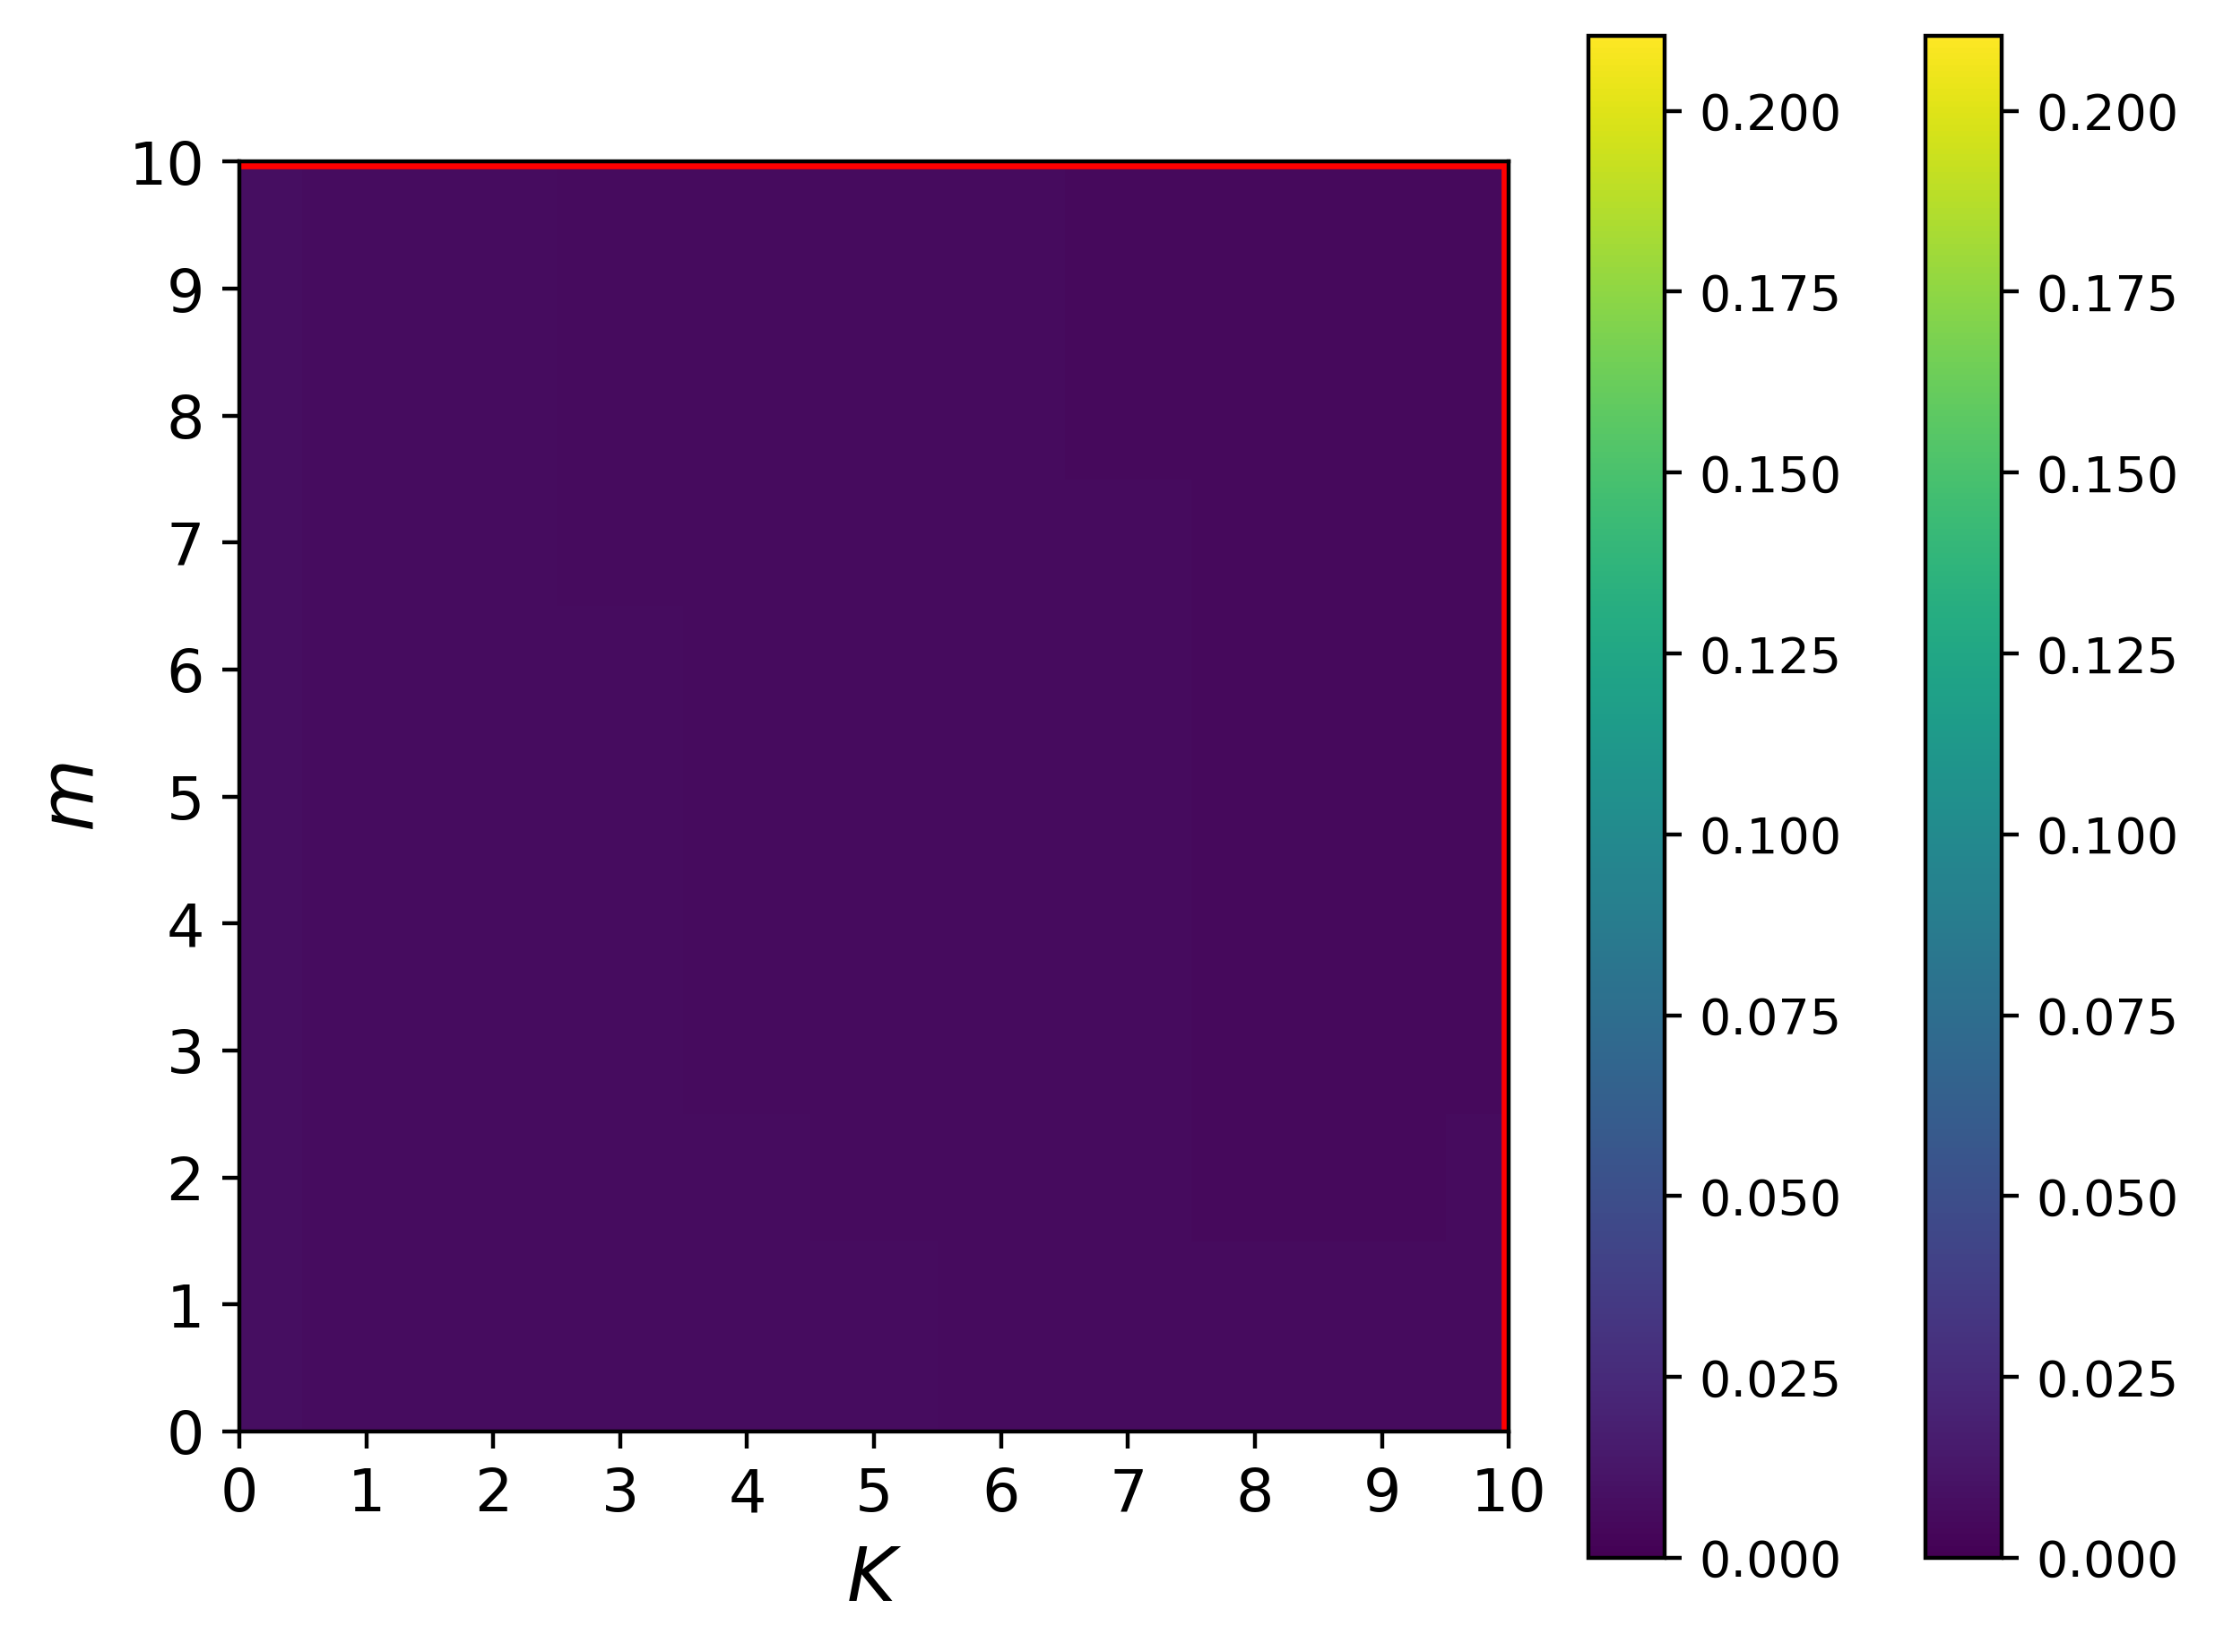

In [51]:
import matplotlib.colors as mcolors
plt.figure(dpi=400)
# imshow를 사용하여 RP2U-RPU의 차이를 시각화
plt.imshow(SIG.T, origin='lower',cmap='Blues', aspect='auto', extent=[Ks.min(), Ks.max(), ms.min(), ms.max()])
plt.imshow(SIG.T, origin='lower',cmap='inferno', aspect='auto', extent=[Ks.min(), Ks.max(), ms.min(), ms.max()],vmax=0.2,vmin=0)

plt.imshow(df_new['sig'].unstack().to_numpy(float).T,origin='lower')
plt.colorbar()
# plt.grid()
plt.colorbar()

# x축과 y축의 tick 설정
plt.xticks(np.linspace(Ks.min(), 10, num=11))
plt.yticks(np.linspace(0, 10, num=11))

# contour 라인을 여러 개 그리기
# contour_levels = np.logspace(-3, 0, 10)  # 원하는 contour 레벨 설정
# contour_colors = ['white', 'red', 'blue', 'green', 'yellow', 'cyan', 'magenta', 'black', 'orange', 'purple']
# im = plt.contour(Ks, ms, (RP2U - RPU).T, levels=contour_levels, colors=contour_colors)

# colorbar 추가
# plt.clabel(im, inline=True, fontsize=10, colors='black')
plt.hlines(10,0,10,color='red',lw=3)
plt.vlines(10,0,10,color='red',lw=3)
plt.xlim(0,10)
plt.ylim(0,10)
plt.xlabel(r'$K$',fontsize=15)
plt.ylabel(r'$m$',fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


In [39]:
m = 10
F = get_r_Fun(m)
R_0u = F['u']['R0'](Ks)
idx = np.isnan(R_0u)
K_urp = Ks[~idx]
R_0u = R_0u[~idx]
OPS = F['u']['OPS'](K_urp)
Ks_,rp_d,rp,rp0_d,rp0_u = get_rp(K_urp,R_0u,OPS,m,MAX=False)
Ks_,rp2_d,rp2,rp20_d,rp20_u = get_rp2(K_urp,R_0u,OPS,m,MAX=False)
Ks_,rp2_d,rp3,rp20_d,rp20_u = get_rp3(K_urp,R_0u,OPS,m,MAX=False)

F_Krp = interpolate.interp1d(Ks_,rp2,bounds_error=False)
F_Krp3 = interpolate.interp1d(Ks_,rp3,bounds_error=False)

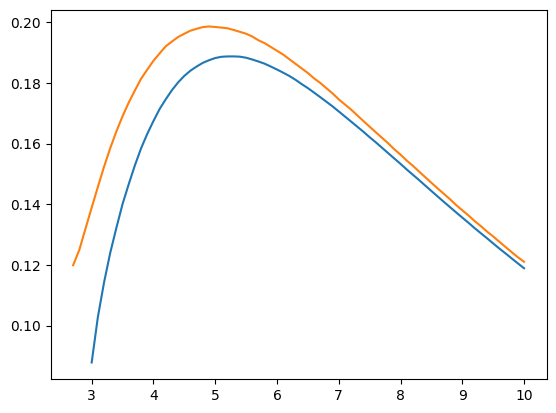

In [47]:
# plt.plot(Ks_,rp0_u)
# plt.plot(Ks_,rp)


plt.plot(Ks_,rp20_u)
plt.plot(Ks_,rp2)

In [ ]:
plt.plot()

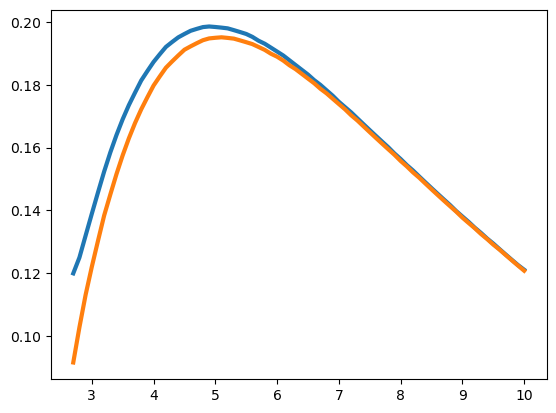

In [21]:
plt.plot(Ks_,rp2,label=r'before',lw=3)
plt.plot(Ks_,rp,label=r'before',lw=3)



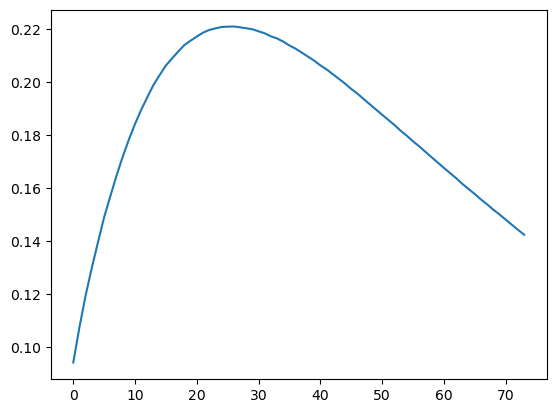

In [28]:
plt.plot(sigma)

# simulation check

In [ ]:
import numpy as np, matplotlib.pyplot as plt
from TO_sim.Sol_Kuramoto import Sol_Kuramoto_mf2 as mf2
from TO_sim.gen_Distribution import Quantile_Normal as Q_Normal
# analytical
from TO_sim.get_sec_r import get_r_Fun,get_rp2


In [118]:
m = 6
DAT = np.load(rf'm={m} secondary cluster.npz',allow_pickle=True)
K_D = DAT['K']

In [119]:
K_D

array([ 4.5,  5. ,  5.5,  6. ,  6.5,  7. ,  7.5, 10. , 11. ])

(-0.02, 0.02)

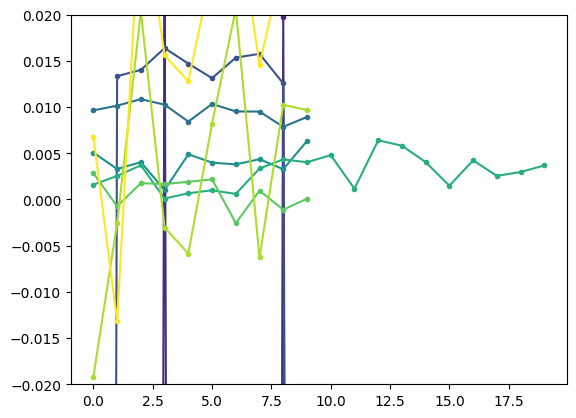

In [121]:
colors = plt.cm.viridis(np.linspace(0, 1, len(K_D)))
num = 0
for K in K_D:

    D_RM = np.array(DAT['RMS'].item()[K])
    D_RP = np.array(DAT['RPS'].item()[K])
    D_R0 = np.array(DAT['R0S'].item()[K])

    F = get_r_Fun(m)
    R_0 = F['u']['R0'](K)
    OPS = F['u']['OPS'](K)
    _,rp_d,rp_u,rp0_d,rp0_u = get_rp(K,R_0,OPS,m,MAX=False)
    sigma = 2*rp_u * np.sqrt(1/2  - m*K*R_0 / (4*(4*m**2 * OPS**2 + 1)) - ((m*K*R_0)/(2*(m**2*OPS**2 + 1)))**2)

    X = 2*rp_u - (D_RM + D_RP)
    Y = D_R0 - R_0
    # plt.scatter( X,Y)
    plt.plot(Y-X,'.-',color=colors[num])
    num += 1
    
    # plt.gca().set_aspect('equal', adjustable='box')
plt.ylim(-0.02,0.02)
# plt.ylim(-0.02,0.002)
# plt.plot(D_RM + D_RP )

# visualization $Kc$

In [10]:
import numpy as np
import matplotlib.pyplot as plt

from numba import njit
from numba.types import intc, CPointer, float64
from numba import cfunc, carray, jit
from scipy import LowLevelCallable
import pandas as pd

from scipy.integrate import quad
from scipy import interpolate
from scipy.integrate import quad
from TO_sim.Get_2ndR_NORM import get_r_rp,Make_R_function
from parfor import parfor
from tqdm.notebook import tqdm

def jit_integrand_function(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        values = carray(xx, n)
        return jitted_function(values[0], values[1])
    return LowLevelCallable(wrapped.ctypes)

def jit_integrand_function2(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        if n < 5:
            raise ValueError("Not enough parameters passed to function.")
        values = carray(xx, n)  # 전달된 모든 파라미터를 포함하는 배열
        return jitted_function(values[0], values[1], values[2], values[3],values[4])
    
    return LowLevelCallable(wrapped.ctypes)


def jit_integrand_function3(integrand_function):
    jitted_function = jit(integrand_function, nopython=True)
    
    @cfunc(float64(intc, CPointer(float64)))
    def wrapped(n, xx):
        if n < 5:
            raise ValueError("Not enough parameters passed to function.")
        values = carray(xx, n)  # 전달된 모든 파라미터를 포함하는 배열
        return jitted_function(values[0], values[1], values[2], values[3],values[4])
    
    return LowLevelCallable(wrapped.ctypes)



@njit
def g(x, mean, std):
    return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)

@njit
def g_sec(x,Or,Om):
    std = 1
    mean = -Or
    g = (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)
    dO = abs(Or-Om)
    return np.where(x<-dO,1e-6,g)

@jit_integrand_function2
def integrand_Rl(x, X,O_O,O_p,m):
    return g(x,O_O,O_p)*np.sqrt(1-(x/X)**2)

@jit_integrand_function2
def integrand_Rd(x, X,O_O,O_p,m):
    if m == 0:
        return 0
    else:
        return X/(2*(m*x**2+1/m))*g(x,O_O,O_p)

@jit_integrand_function2
def integrand_Rl2(x, X,O_pm,shift_O,m):
    return g_sec(x,O_pm+shift_O,O_pm)*np.sqrt(1-(x/X)**2)

@jit_integrand_function2
def integrand_Rd2(x, X,O_pm,shift_O,m):
    return X/(2*(m*(x+O_pm+shift_O)**2+1/m))*g_sec(x,O_pm+shift_O,O_pm)
    # return 1/(2*(m*(x)**2+1/m))*g_sec(x,O_pm+shift_O,O_pm)


@jit_integrand_function2
def integrand_Rl3(x, X,O_pm,shift_O,m):
    return g(x,0,1)*np.sqrt(1-((x-O_pm-shift_O)/X)**2)


@jit_integrand_function2
def integrand_Rd3(x, X,O_pm,shift_O,m):
    return X/(2*(m*(x-O_pm-shift_O)**2+1/m))*g(x,0,1)

In [11]:
def get_Kc(m):
    Xs = np.logspace(-15,-3,2000)[:10]

    R_ls = []
    R_drs = []


    for X in Xs:
        a = 1/np.sqrt(X*m)
        b = 4/np.pi * a - 0.3056*a**3
        b = np.where(np.where(a>1.193,1,b)>=1,1,b)

        omega_p = b*X
        R_l,err = quad(integrand_Rl, -omega_p,omega_p,args=(X,0,1,m),limit=200)
        R_dr,err = quad(integrand_Rd,omega_p,np.inf,args=(X,0,1,m),limit=200)
        R_ls.append(R_l)
        R_drs.append(R_dr)


    R0 = np.array(R_ls)
    RD = 2*np.array(R_drs)
    R = R0 -RD
    Kc = (1/(R/Xs))[0]
    return Kc

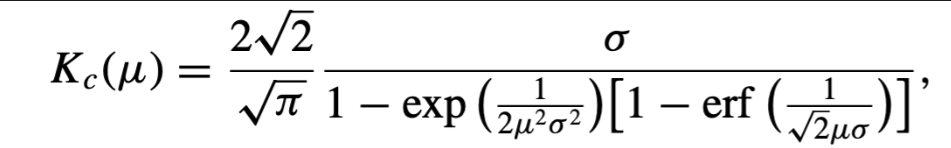

In [12]:
from scipy.special import erf

def K_c(m,sigma=1):
    A = 2*np.sqrt(2/np.pi)
    B = 1 - np.exp(1/(2*m**2*sigma**2)) * (1-erf(1/(np.sqrt(2)*m*sigma)))
    return A/B*sigma

In [13]:
ms_ =  np.linspace(0,10,1001)
Kc = np.array([*map(get_Kc,ms_)])

/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_29924/3913430221.py:9: RuntimeWarning: divide by zero encountered in scalar divide
  a = 1/np.sqrt(X*m)
/var/folders/lj/v2s5sd8n1cv2xdh0yw2kf0x00000gn/T/ipykernel_29924/3913430221.py:10: RuntimeWarning: invalid value encountered in scalar subtract
  b = 4/np.pi * a - 0.3056*a**3


In [14]:
from scipy.interpolate import interp1d
x = 0.21253842513951482,0.09586833640423464,0.11819743293463669,0.140501545860529,0.24263764404609467,0.28409481277911364,0.30641766340838816,0.33196339901939353,0.37025389588082813,0.4117891383779395,0.4533212579244872,0.5874176321788827,0.6545048561881266,0.7791543049873522,0.8910652384372755,1.1500858811405015,1.3260079322944318,1.5499547172168262,1.764329658661503,2.036304300302926,2.241113644171013,2.5291496205615065,2.878026919833859,3.2781049935979514,3.777411698572812,4.34716592236345,4.9841322881858785,
y = 0.17164062982401962,0.04975609756097554,0.07414634146341459,0.10634146341463402,0.19902439024390228,0.24780487804878037,0.27414634146341443,0.29365853658536567,0.3317073170731706,0.35609756097560963,0.38146341463414624,0.4897560975609755,0.5317073170731705,0.5912195121951218,0.6302439024390243,0.7121951219512193,0.7541463414634144,0.7931707317073169,0.8224390243902437,0.8575609756097559,0.875121951219512,0.8926829268292681,0.9034146341463413,0.9190243902439023,0.9356097560975608,0.9443902439024388,0.9560975609756095,
f_cubic = interp1d(x, y, kind='quadratic', bounds_error=False, fill_value=np.nan)

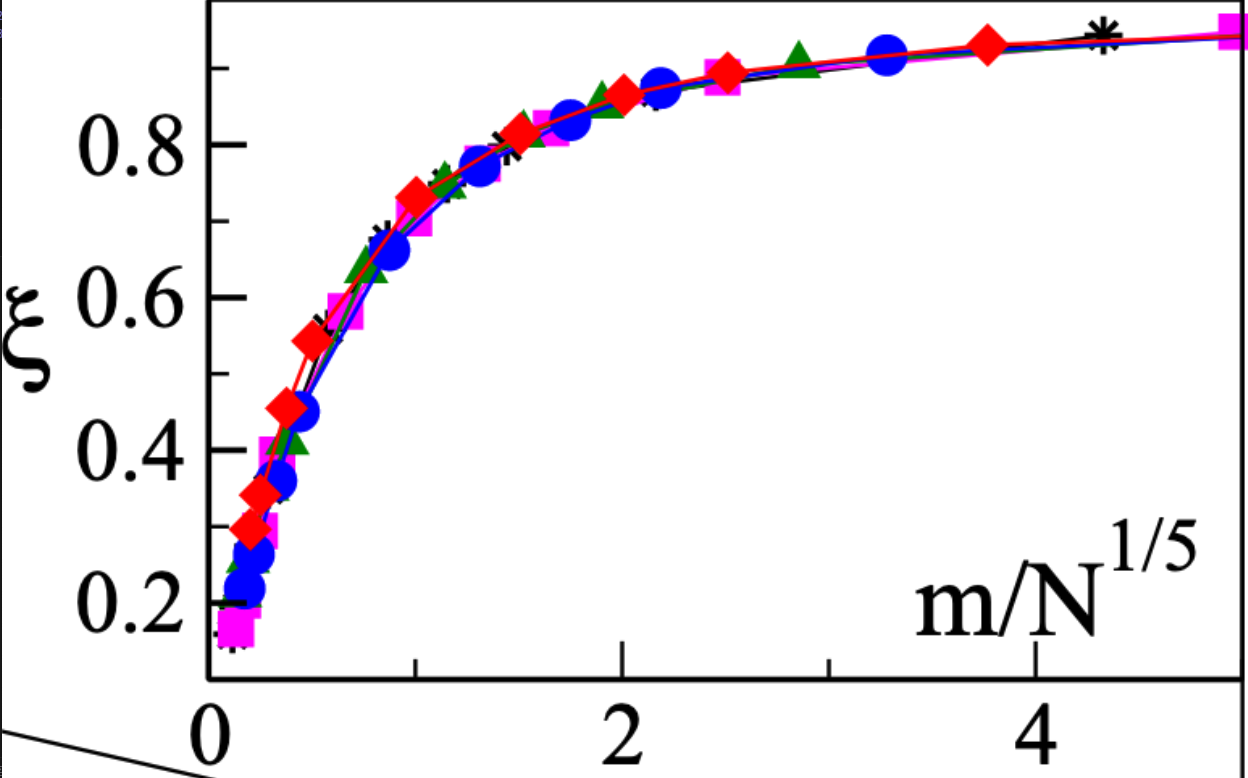
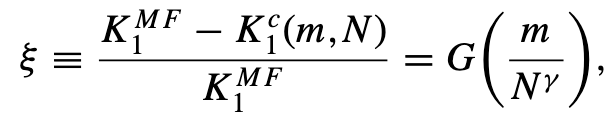

In [15]:
coefficients = np.polyfit(y, x, 10)
f = np.poly1d(coefficients)
ys = np.linspace(0.03,1,10001)
G = interp1d(f(ys), ys, kind='slinear', bounds_error=False, fill_value=np.nan)
# plt.plot(f(ys),ys)
# plt.plot(x,y)


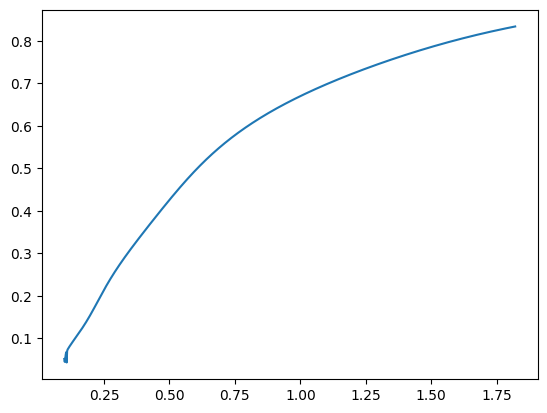

In [16]:
M = ms_ / (5000**0.2)
CHI = G(M)
K_cn = Kc - CHI * Kc 
plt.plot(M,CHI)


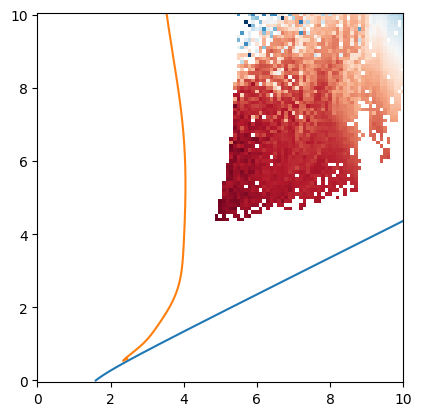

In [17]:
MM,KK = np.meshgrid(ms,Ks,indexing='ij')

plt.pcolormesh(MM,KK,DRP_AS,cmap='RdBu',shading='auto')
plt.plot(Kc,ms_)
plt.plot(K_cn,ms_)
plt.xlim(0,10)
plt.gca().set_aspect('equal', adjustable='box')

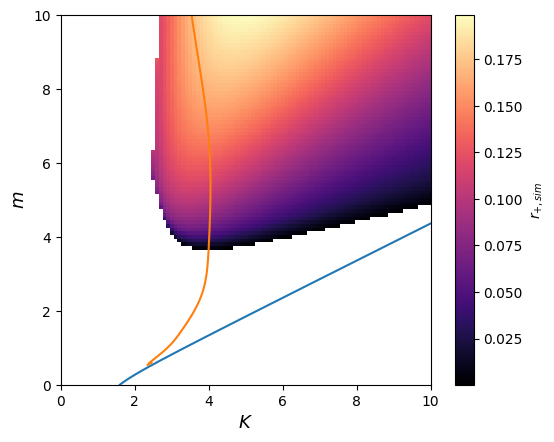

In [25]:
plt.pcolormesh(MM,KK,A_RPU,shading='auto',cmap='magma')
plt.plot(Kc,ms_)
plt.plot(K_cn,ms_)

plt.ylabel(r'$m$', fontsize=13)
plt.xlabel(r'$K$', fontsize=13)
plt.xlim(0,10)
plt.ylim(0,10)
plt.gca().set_aspect('equal', adjustable='box')
plt.colorbar(label=r'$r_{+,sim}$')

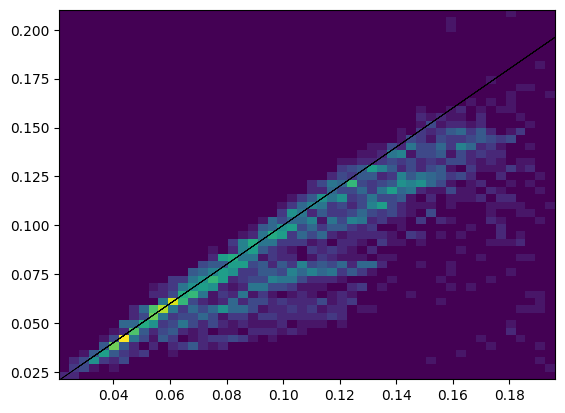

In [37]:
# Filter out NaN values from A_RPU and RP
valid_indices = ~np.isnan(A_RPU.flatten()) & ~np.isnan(RP.flatten())
filtered_A_RPU = A_RP0U.flatten()[valid_indices]
filtered_RP = RP.flatten()[valid_indices]

# Plot the 2D histogram
plt.hist2d(filtered_A_RPU, filtered_RP, bins=50, cmap='viridis')

# Plot the diagonal line
plt.plot(filtered_RP, filtered_RP, lw=0.5, c='k')
# plt.gca().set_aspect('equal', adjustable='box')

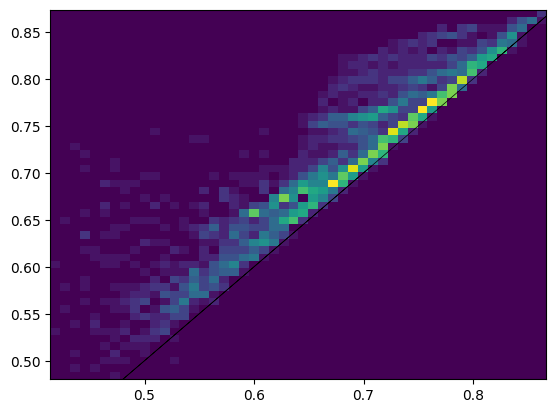

In [38]:
# Filter out NaN values from A_RPU and RP

filtered_A_RPU = A_R0.flatten()[valid_indices]
filtered_RP = R0.flatten()[valid_indices]

# Plot the 2D histogram
plt.hist2d(filtered_A_RPU, filtered_RP, bins=50, cmap='viridis')

# Plot the diagonal line
plt.plot(filtered_RP, filtered_RP, lw=0.5, c='k')
# plt.gca().set_aspect('equal', adjustable='box')

In [ ]:
plt.plot(rp)